# **Algorhythm**

## **Model Selection and Optimization**

This notebook focuses on the process of **selecting, comparing, and optimizing machine learning models** for predicting user recommendations in the Algorhythm dataset. The goal is to identify models that outperform the baseline heuristic, providing better accuracy, robustness, and generalization.

Multiple candidate models will be evaluated and tuned using cross-validation, hyperparameter optimization, and appropriate performance metrics. The process ensures that the selected model not only improves predictive power but also maintains interpretability and efficiency for practical use.

All steps are implemented using **scikit-learn** and other relevant libraries, ensuring a reproducible and well-structured workflow.

`Simón Correa Marín`  
`Luis Felipe Ospina Giraldo`


### **1. Import Libraries and Configurations**


In [115]:
# base libraries for data science
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

import warnings
warnings.simplefilter("ignore", category=UserWarning)

# base libraries for data science

from pathlib import Path
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer

### **2. Load Data**


In [116]:
DATA_DIR = Path("../../data/02_intermediate")

# Load the Algorhythm dataset (parquet)
algorhythm_df = pd.read_parquet(DATA_DIR / "algorhythm_fixed.parquet")

In [117]:
# print library version for reproducibility

print("Pandas version: ", pd.__version__)

Pandas version:  2.2.3


### **3. Data Preparation**


I'll be using all columns since I found no strange correlations.


In [118]:
algorhythm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   age                 2332 non-null   float64 
 1   album_name          2332 non-null   category
 2   album_popularity    2332 non-null   float64 
 3   artist_genres       1118 non-null   category
 4   artist_name         2332 non-null   category
 5   artist_popularity   2332 non-null   float64 
 6   chart_chart_name    473 non-null    category
 7   chart_genres        387 non-null    category
 8   chart_track_name    473 non-null    category
 9   chart_popularity    473 non-null    float64 
 10  chart_position      473 non-null    float64 
 11  gender              2332 non-null   category
 12  is_liked            2805 non-null   bool    
 13  is_recent_play      2805 non-null   bool    
 14  is_top_track        2805 non-null   bool    
 15  location            2332 non-null   ca

#### **Missing Values**


In [119]:
algorhythm_df.isna().sum()

age                    473
album_name             473
album_popularity       473
artist_genres         1687
artist_name            473
artist_popularity      473
chart_chart_name      2332
chart_genres          2418
chart_track_name      2332
chart_popularity      2332
chart_position        2332
gender                 473
is_liked                 0
is_recent_play           0
is_top_track             0
location               473
music_profile          473
track_name             473
track_popularity       473
album_age_days         504
chart_age_days        2332
track_age_days         504
played_day_of_week     473
played_hour            473
is_recommended           0
dtype: int64

#### **Duplicated Data**


In [120]:
duplicate_rows = algorhythm_df.duplicated().sum()
print("Number of duplicate rows: ", duplicate_rows)

Number of duplicate rows:  289


In [121]:
algorhythm_df = algorhythm_df.drop_duplicates()
algorhythm_df.shape

(2516, 25)

There are 508 rows left after deleting duplicated rows


In [122]:
# Missing values after dropping duplicates
algorhythm_df.isna().sum()

age                    473
album_name             473
album_popularity       473
artist_genres         1496
artist_name            473
artist_popularity      473
chart_chart_name      2043
chart_genres          2129
chart_track_name      2043
chart_popularity      2043
chart_position        2043
gender                 473
is_liked                 0
is_recent_play           0
is_top_track             0
location               473
music_profile          473
track_name             473
track_popularity       473
album_age_days         492
chart_age_days        2043
track_age_days         492
played_day_of_week     473
played_hour            473
is_recommended           0
dtype: int64

In [123]:
ordinal_categorical_cols = [
    "chart_position"
]

# Nominal categorical columns
nominal_categorical_cols = [
    "album_name",
    "artist_genres",
    "artist_name",
    "gender",
    "location",
    "music_profile",
    "track_name",
    "chart_chart_name",
    "chart_genres",
    "chart_track_name"
]

# Ordinal and Nominal Categorical columns
categorical_cols = ordinal_categorical_cols + nominal_categorical_cols
algorhythm_df[categorical_cols] = algorhythm_df[categorical_cols].astype("category")

In [124]:
# Encode target variable
algorhythm_df["is_recommended"] = algorhythm_df["is_recommended"].astype("int64")
# True = 1, False = 0

In [125]:
columns_to_drop = ["played_day_of_week", "played_hour", "gender", "location", "music_profile"]

# Drop columns that are not needed for modeling
algorhythm_df = algorhythm_df.drop(columns=columns_to_drop)

In [126]:
df_corr = algorhythm_df.copy()

# Convert all boolean columns to int
boolean_cols = [
    "is_liked",
    "is_recent_play",
    "is_top_track",
    "is_recommended"  # Target variable
]
df_corr[boolean_cols] = df_corr[boolean_cols].astype("int")
df_corr[boolean_cols] = df_corr[boolean_cols].astype("category")

In [127]:
from dython.nominal import associations

# Calculate the correlation matrix including the categorical columns
correlation_matrix = associations(df_corr, nominal_columns="auto", mark_columns=True, plot=False)

corr_df = correlation_matrix["corr"]
correlation_with_target = corr_df.loc[:, 'is_recommended (nom)'].sort_values(ascending=False)
print(correlation_with_target)

age (con)                  1.000000
is_recommended (nom)       1.000000
chart_chart_name (nom)     0.999602
chart_position (nom)       0.950652
is_recent_play (nom)       0.946016
is_top_track (nom)         0.935749
chart_popularity (con)     0.932024
chart_track_name (nom)     0.908503
artist_popularity (con)    0.893572
chart_genres (nom)         0.871544
artist_name (nom)          0.870949
track_popularity (con)     0.714483
chart_age_days (con)       0.713632
album_name (nom)           0.687715
track_age_days (con)       0.513955
album_age_days (con)       0.513955
track_name (nom)           0.500199
artist_genres (nom)        0.299833
is_liked (nom)             0.090493
album_popularity (con)     0.065694
Name: is_recommended (nom), dtype: float64


**Irrelevant variables**

- is_liked (nom) 0.090493
- album_popularity (con) 0.065694


In [128]:
# Drop columns with low correlation with the target
algorhythm_df.drop(columns=['is_liked', 'album_popularity'], inplace=True)

In [129]:
algorhythm_df.sample(10)

,age,album_name,artist_genres,artist_name,artist_popularity,chart_chart_name,chart_genres,chart_track_name,chart_popularity,chart_position,is_recent_play,is_top_track,track_name,track_popularity,album_age_days,chart_age_days,track_age_days,is_recommended
1059,21.0,VACAXIONES,"reggaeton, urbano latino",Feid,89.0,NaN,NaN,NaN,NaN,NaN,False,False,VACAXIONES,53.0,1312.0,NaN,1312.0,1
1670,21.0,17,emo rap,XXXTENTACION,87.0,NaN,NaN,NaN,NaN,NaN,False,False,Everybody Dies In Their Nightmares,82.0,2838.0,NaN,2838.0,1
1864,21.0,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",NaN,DJ Snake,80.0,NaN,NaN,NaN,NaN,NaN,False,False,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",75.0,2439.0,NaN,2439.0,1
1837,21.0,TELÉFONO (Remix),NaN,Aitana,76.0,NaN,NaN,NaN,NaN,NaN,False,False,TELÉFONO - Remix,45.0,2385.0,NaN,2385.0,1
2776,NaN,NaN,NaN,NaN,NaN,Top 50 Colombia,"reggaeton, colombian pop, pop urbano",Volver,85.0,72.0,True,True,NaN,NaN,NaN,8.0,NaN,0
5,21.0,Submarine,bedroom pop,The Marías,86.0,NaN,NaN,NaN,NaN,NaN,False,True,No One Noticed,93.0,367.0,NaN,367.0,1
1722,21.0,La Isla (with Sech & Dalex feat. Justin Quiles...,"reggaeton, urbano latino",Dímelo Flow,70.0,NaN,NaN,NaN,NaN,NaN,False,False,La Isla (with Sech & Dalex feat. Justin Quiles...,52.0,2012.0,NaN,2012.0,1
2412,NaN,NaN,NaN,NaN,NaN,Today's Top Hits,"country, country hip hop",Love You Again,63.0,81.0,True,True,NaN,NaN,NaN,388.0,NaN,0
537,21.0,Cigarettes After Sex,dream pop,Cigarettes After Sex,86.0,NaN,NaN,NaN,NaN,NaN,False,False,Sweet,51.0,2915.0,NaN,2915.0,1
713,21.0,PORTALS (Deluxe),NaN,Melanie Martinez,78.0,NaN,NaN,NaN,NaN,NaN,False,False,THE CONTORTIONIST,55.0,789.0,NaN,789.0,1


In [130]:
algorhythm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2516 entries, 0 to 2804
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                2043 non-null   float64 
 1   album_name         2043 non-null   category
 2   artist_genres      1020 non-null   category
 3   artist_name        2043 non-null   category
 4   artist_popularity  2043 non-null   float64 
 5   chart_chart_name   473 non-null    category
 6   chart_genres       387 non-null    category
 7   chart_track_name   473 non-null    category
 8   chart_popularity   473 non-null    float64 
 9   chart_position     473 non-null    category
 10  is_recent_play     2516 non-null   bool    
 11  is_top_track       2516 non-null   bool    
 12  track_name         2043 non-null   category
 13  track_popularity   2043 non-null   float64 
 14  album_age_days     2024 non-null   float64 
 15  chart_age_days     473 non-null    float64 
 16  track_age_d

### **3. Feature Engineering**


In [131]:
# Ordinal categorical columns (keep only those not descriptive)
ordinal_categorical_cols = [
    "chart_position"
]

# Nominal categorical columns (excluded descriptive ones)
nominal_categorical_cols = [
    "artist_genres",
    "chart_genres"
]

# Boolean columns (target included)
boolean_cols = [
    "is_recent_play",
    "is_top_track",
    #"is_recommended"  # Target variable
]

# Discrete numerical columns (kept all as no descriptive excluded)
disc_numerical_cols = [
    "age",
    "artist_popularity",
    "track_popularity",
    "chart_popularity"
]

# Continuous numerical columns (kept all as no descriptive excluded)
cont_numerical_cols = [
    "album_age_days",
    "track_age_days",
    "chart_age_days"
]

In [132]:
# List of descriptive columns to exclude during model training
descriptive_cols = [
    "album_name",
    "artist_name",
    "track_name",
    "chart_chart_name",
    "chart_track_name"
]

# Create a new DataFrame for training that excludes these columns
algorhythm_train_df = algorhythm_df.drop(columns=descriptive_cols)

# Check the columns left for training
print("Columns used for training:")
print(algorhythm_train_df.columns)

Columns used for training:
Index(['age', 'artist_genres', 'artist_popularity', 'chart_genres',
       'chart_popularity', 'chart_position', 'is_recent_play', 'is_top_track',
       'track_popularity', 'album_age_days', 'chart_age_days',
       'track_age_days', 'is_recommended'],
      dtype='object')


In [133]:
def simplify_and_clean_genres(genre_str):
    """
    Simplifies genre string by taking the first genre separated by commas,
    then cleans the genre string by lowercasing, replacing spaces/commas with underscores,
    removing special characters, and removing repeated underscores.
    """
    if not isinstance(genre_str, str):
        return genre_str  # handle NaN or None gracefully
    
    # Step 1: Simplify - take the first genre only
    first_genre = genre_str.split(',')[0].strip().lower()
    
    # Step 2: Clean - normalize string
    cleaned = first_genre
    cleaned = re.sub(r'[ ,]+', '_', cleaned)           # Replace spaces and commas with underscore
    cleaned = re.sub(r'[^a-z0-9_]', '', cleaned)       # Remove non-alphanumeric and non-underscore chars
    cleaned = re.sub(r'_+', '_', cleaned)               # Replace multiple underscores with one
    
    return cleaned

# Apply to relevant columns
for col in ['artist_genres', 'chart_genres']:
    if col in algorhythm_train_df.columns:
        algorhythm_train_df[col] = algorhythm_train_df[col].apply(simplify_and_clean_genres)

In [134]:
# # Suppose you have prediction results in this DataFrame (or Series)
# predictions = algorhythm_train_df.copy()
# predictions['predicted_recommendation'] = model.predict(X_train)  # Example

# # Join descriptive columns from original df by index
# final_results = predictions.join(algorhythm_df[descriptive_cols])

# # Now final_results has predictions plus all descriptive info for display/export
# print(final_results.head())

### **Handling Missing Values in Chart Features**


In [135]:
class NumericWithIndicator(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value=-1):
        self.fill_value = fill_value
        self.imputer = SimpleImputer(strategy="constant", fill_value=fill_value)
        self.indicator = MissingIndicator(features='missing-only')
    
    def fit(self, X, y=None):
        self.imputer.fit(X)
        self.indicator.fit(X)
        return self
    
    def transform(self, X):
        X_imputed = self.imputer.transform(X)
        X_ind = self.indicator.transform(X)
        return np.hstack((X_imputed, X_ind))

    def get_feature_names_out(self, input_features=None):
        # input_features: list of original column names passed to this transformer
        if input_features is None:
            input_features = []

        n_features_in = len(input_features)
        # Imputed features names stay the same
        imputed_features = list(input_features)

        # Missing indicator features get suffix "_missing_indicator"
        indicator_features = [f"{feat}_missing_indicator" for feat in input_features]

        return imputed_features + indicator_features

# Define columns explicitly for chart features
chart_categorical_cols = ["chart_genres"]
chart_numerical_cols = ["chart_popularity", "chart_age_days", "chart_position"]

#### **Pipeline**


In [136]:
# Updated categorical chart pipeline
chart_nom_categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="No_Chart")),
        ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore")),
    ]
)

# Updated numerical chart pipeline with missing indicator
chart_num_pipe = Pipeline(
    steps=[
        ("imputer_with_ind", NumericWithIndicator(fill_value=-1)),
    ]
)

In [137]:
# Other pipelines 

numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

nom_categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore")),
    ]
)

ord_categorical_ord_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ]
)

boolean_pipe = Pipeline(
    steps=[
        ("to_int", FunctionTransformer(lambda x: x.astype("int64"), feature_names_out="one-to-one")),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore")),
    ]
)

In [138]:
# Combine all pipelines in ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, disc_numerical_cols + cont_numerical_cols),
        ("nominal_categoric", nom_categorical_pipe, nominal_categorical_cols),
        ("ordinal_categoric", ord_categorical_ord_pipe, ordinal_categorical_cols),
        ("boolean", boolean_pipe, boolean_cols),
        ("chart_nominal", chart_nom_categorical_pipe, chart_categorical_cols),
        ("chart_numeric", chart_num_pipe, chart_numerical_cols),
    ],
    sparse_threshold=0 
)

In [139]:
preprocessor

ColumnTransformer(sparse_threshold=0,
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age', 'artist_popularity',
                                  'track_popularity', 'chart_popularity',
                                  'album_age_days', 'track_age_days',
                                  'chart_age_days']),
                                ('nominal_categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEn...
                                 ['is_recent_play', 'is_top_track']),
                                ('chart_nominal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='No_Chart',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['chart_genres']),
                                ('chart_numeric',
                                 Pipeline(steps=[('imputer_with_ind',
                                                  NumericWithIndicator())]),
                                 ['chart_popularity', 'chart_age_days',
                                  'chart_position'])])

#### **Train/Test split**


In [140]:
X_features = algorhythm_train_df.drop("is_recommended", axis="columns")
Y_target = algorhythm_train_df["is_recommended"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

In [141]:
x_train.shape, y_train.shape

((2012, 12), (2012,))

In [142]:
x_test.shape, y_test.shape

((504, 12), (504,))

In [143]:
print(x_train.dtypes)

age                   float64
artist_genres          object
artist_popularity     float64
chart_genres           object
chart_popularity      float64
chart_position       category
is_recent_play           bool
is_top_track             bool
track_popularity      float64
album_age_days        float64
chart_age_days        float64
track_age_days        float64
dtype: object


#### **Preprocessing Pipeline**


In [144]:
preprocessor.fit(x_train)

ColumnTransformer(sparse_threshold=0,
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age', 'artist_popularity',
                                  'track_popularity', 'chart_popularity',
                                  'album_age_days', 'track_age_days',
                                  'chart_age_days']),
                                ('nominal_categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEn...
                                 ['is_recent_play', 'is_top_track']),
                                ('chart_nominal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='No_Chart',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['chart_genres']),
                                ('chart_numeric',
                                 Pipeline(steps=[('imputer_with_ind',
                                                  NumericWithIndicator())]),
                                 ['chart_popularity', 'chart_age_days',
                                  'chart_position'])])

In [145]:
def get_feature_names_from_column_transformer(column_transformer, input_features):
    """
    Extracts the feature names produced by a fitted ColumnTransformer, including names
    generated by individual transformers like OneHotEncoder, and handles cases where
    transformers may or may not implement get_feature_names_out.

    Parameters:
    - column_transformer: A fitted sklearn ColumnTransformer object.
    - input_features: List or Index of original input feature names (e.g. x_train.columns).

    Returns:
    - feature_names: List of all transformed feature names in order.
    """
    feature_names = []

    # Iterate over all transformers inside the ColumnTransformer
    for name, transformer, columns in column_transformer.transformers_:
        # Skip any 'remainder' transformers (like passthrough or drop)
        if name == 'remainder':
            continue

        # Normalize columns variable to a list of column names
        # It can be a slice, list, numpy array, or a single string
        if isinstance(columns, slice):
            # If slice, use it to slice the input_features list/index
            cols = list(input_features[columns])
        elif isinstance(columns, (list, np.ndarray)):
            # If list or array, just convert to list
            cols = list(columns)
        else:
            # Otherwise assume a single column name string
            cols = [columns]

        # Check if the transformer has a method to get output feature names
        if hasattr(transformer, 'get_feature_names_out'):
            try:
                # Try to get transformed feature names using input columns as context
                names = transformer.get_feature_names_out(cols)
            except Exception:
                # If an error happens (e.g. custom transformers), fallback:
                if hasattr(transformer, 'get_feature_names_out'):
                    # Retry if possible
                    names = transformer.get_feature_names_out(cols)
                else:
                    # Otherwise, just use original column names (no expansion)
                    names = cols
            feature_names.extend(names)
        else:
            # If no get_feature_names_out method, just use original column names
            feature_names.extend(cols)

    return feature_names

feature_names = get_feature_names_from_column_transformer(preprocessor, x_train.columns)
print(f"Number of features: {len(feature_names)}")
print(feature_names)

Number of features: 155
['age', 'artist_popularity', 'track_popularity', 'chart_popularity', 'album_age_days', 'track_age_days', 'chart_age_days', 'artist_genres_afroswing', 'artist_genres_ambient_folk', 'artist_genres_anime', 'artist_genres_argentine_rock', 'artist_genres_argentine_trap', 'artist_genres_art_pop', 'artist_genres_art_rock', 'artist_genres_bachata', 'artist_genres_baroque_pop', 'artist_genres_bass_house', 'artist_genres_bedroom_pop', 'artist_genres_brazilian_bass', 'artist_genres_brazilian_funk', 'artist_genres_brazilian_pop', 'artist_genres_breakcore', 'artist_genres_brooklyn_drill', 'artist_genres_chanson', 'artist_genres_chilean_trap', 'artist_genres_christmas', 'artist_genres_classic_rock', 'artist_genres_cloud_rap', 'artist_genres_cold_wave', 'artist_genres_colombian_pop', 'artist_genres_corrido', 'artist_genres_corridos_tumbados', 'artist_genres_dancehall', 'artist_genres_dark_rb', 'artist_genres_darkwave', 'artist_genres_dream_pop', 'artist_genres_edm', 'artist_ge

In [146]:
# Transform data
x_train_transformed = preprocessor.transform(x_train)

x_train_transformed = preprocessor.transform(x_train)

# Convert to dense only if sparse
if hasattr(x_train_transformed, "toarray"):
    x_train_dense = x_train_transformed.toarray()
else:
    x_train_dense = x_train_transformed  # already dense numpy array

# Now create DataFrame
x_train_transformed_df = pd.DataFrame(x_train_dense, columns=feature_names)
print(x_train_transformed_df.shape)
x_train_transformed_df.head()

(2012, 155)


/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,age,artist_popularity,track_popularity,chart_popularity,album_age_days,track_age_days,chart_age_days,artist_genres_afroswing,artist_genres_ambient_folk,artist_genres_anime,...,chart_genres_texas_country,chart_genres_trap_latino,chart_genres_urbano_latino,chart_genres_vallenato,chart_popularity,chart_age_days,chart_position,chart_popularity_missing_indicator,chart_age_days_missing_indicator,chart_position_missing_indicator
0,21.0,85.0,3.0,70.0,815.0,815.0,388.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,1.0
1,21.0,82.0,63.0,70.0,633.0,633.0,388.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,1.0
2,21.0,87.0,32.0,70.0,1515.0,1515.0,388.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,1.0
3,21.0,85.0,74.0,70.0,2418.0,2418.0,388.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,1.0
4,21.0,75.0,67.0,70.0,2390.0,2390.0,388.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,1.0


In [147]:
x_train.head()

,age,artist_genres,artist_popularity,chart_genres,chart_popularity,chart_position,is_recent_play,is_top_track,track_popularity,album_age_days,chart_age_days,track_age_days
746,21.0,NaN,85.0,NaN,NaN,NaN,False,False,3.0,815.0,NaN,815.0
276,21.0,NaN,82.0,NaN,NaN,NaN,False,False,63.0,633.0,NaN,633.0
1307,21.0,NaN,87.0,NaN,NaN,NaN,False,False,32.0,1515.0,NaN,1515.0
1636,21.0,classic_rock,85.0,NaN,NaN,NaN,False,False,74.0,2418.0,NaN,2418.0
2063,21.0,NaN,75.0,NaN,NaN,NaN,False,False,67.0,2390.0,NaN,2390.0


In [148]:
x_train_transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2012 entries, 0 to 2011
Columns: 155 entries, age to chart_position_missing_indicator
dtypes: float64(155)
memory usage: 2.4 MB


### **4. Models**

Best Practices is to import the libraries at the beginning of the notebook, but for this notebook, the libraries are imported in the cell where they are used.

In this experiments Basic Machine Learning models are used, and the models are:

- Logistic Regression
- Linear Discriminant Analysis
- Stochastic Gradient Descent classifier
- Linear Support Vector Machine
- Radius Neighbors Classifier
- Gaussian Naive Bayes
- Decision Tree
- Random Forest


In [149]:
# Model libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

#### **Basic Model Selection**

The models are trained with the default hyperparameters, and the models with the best performance will be selected to be tuned in the next step.


#### **Helping functions**


In [150]:
def summarize_classification(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    roc = roc_auc_score(y_test, y_pred) if len(set(y_test)) == 2 else None  # AUC only for binary

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1, "roc": roc}

In [151]:
from sklearn.base import BaseEstimator, TransformerMixin

class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if hasattr(X, "toarray"):
            return X.toarray()
        else:
            return X

In [152]:
def build_model(
    classifier_fn,
    preprocessor: ColumnTransformer,
    data_params: dict,
    test_frac: float = 0.2,
) -> dict:
    """
    Function to train a classification model and return performance metrics,
    plus transformed training features as a DataFrame with correct feature names.

    Args:
        classifier_fn: classification model instance (e.g., LogisticRegression())
        preprocessor (ColumnTransformer): fitted sklearn preprocessor pipeline
        data_params (dict): dictionary containing:
            - 'name_of_y_col': str, target column name
            - 'names_of_x_cols': list of str, feature column names
            - 'dataset': pd.DataFrame, full dataset
        test_frac (float): fraction of data to reserve for testing (default 0.2)

    Returns:
        dict: {
            "train": train_summary_metrics,
            "test": test_summary_metrics,
            "x_train_transformed_df": DataFrame with transformed training features
        }
    """

    # Extract parameters
    name_of_y_col = data_params["name_of_y_col"]
    names_of_x_cols = data_params["names_of_x_cols"]
    dataset = data_params["dataset"]

    # Separate features and target
    X = dataset[names_of_x_cols]
    Y = dataset[name_of_y_col]

    # Split into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_frac, random_state=1234
    )

    # Fit preprocessor on training data (if not already fitted)
    preprocessor.fit(x_train)

    # Get feature names from preprocessor
    feature_names = get_feature_names_from_column_transformer(preprocessor, x_train.columns)

    # Transform training data
    x_train_transformed = preprocessor.transform(x_train)

    # Convert to dense array if sparse
    if hasattr(x_train_transformed, "toarray"):
        x_train_dense = x_train_transformed.toarray()
    else:
        x_train_dense = x_train_transformed

    # Create DataFrame with proper feature names and original index
    x_train_transformed_df = pd.DataFrame(x_train_dense, columns=feature_names, index=x_train.index)

    # Create pipeline with preprocessor and classifier
    classifier_pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("to_dense", DenseTransformer()),  # Add this step
        ("model", classifier_fn),
    ])
    # Train the pipeline
    model = classifier_pipe.fit(x_train, y_train)

    print(hasattr(model, "fit"))   # debe ser True
    print(hasattr(model, "predict"))  # debe ser True
    print(hasattr(model, "named_steps"))  # si es pipeline
    
    # Predict on train and test sets
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    # Compute performance summaries
    train_summary = summarize_classification(y_train, y_pred_train)
    test_summary = summarize_classification(y_test, y_pred_test)

    return {
        "train": train_summary,
        "test": test_summary,
        "x_train_transformed_df": x_train_transformed_df,
    }

#### **First Selection of Models**

The idea is to do a simple train an evaluate the models to see which ones are the worst to discard them.


In [153]:
FEATURES = list(x_train.columns)
FEATURES

['age',
 'artist_genres',
 'artist_popularity',
 'chart_genres',
 'chart_popularity',
 'chart_position',
 'is_recent_play',
 'is_top_track',
 'track_popularity',
 'album_age_days',
 'chart_age_days',
 'track_age_days']

#### **Simple Training and Evaluation**


In [114]:
result_dict = {}
models = {
    "logistic": LogisticRegression(solver="liblinear"),
    "lda": LinearDiscriminantAnalysis(),
    "sgd": SGDClassifier(),
    "svc": LinearSVC(C=1.0, max_iter=1000, tol=1e-3, dual=False),
    "radius_neighbors": RadiusNeighborsClassifier(radius=60.0, outlier_label=-1),
    "naive_bayes": GaussianNB(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
}

data_params = {
    "name_of_y_col": "is_recommended",
    "names_of_x_cols": FEATURES,
    "dataset": algorhythm_train_df,
}

for model_name, model in models.items():
    print(f"Training {model_name} - model type: {type(model)}")
    result_dict[model_name] = build_model(model, preprocessor, data_params)

Training logistic - model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Training lda - model type: <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>


/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of 

Training sgd - model type: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
Training svc - model type: <class 'sklearn.svm._classes.LinearSVC'>
Training radius_neighbors - model type: <class 'sklearn.neighbors._classification.RadiusNeighborsClassifier'>


/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of 

Training naive_bayes - model type: <class 'sklearn.naive_bayes.GaussianNB'>
Training decision_tree - model type: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Training random_forest - model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of 

#### **Model Comparison**


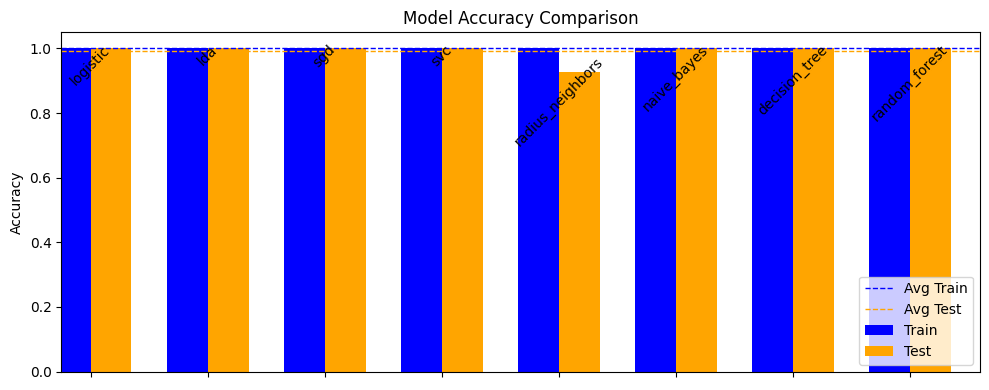

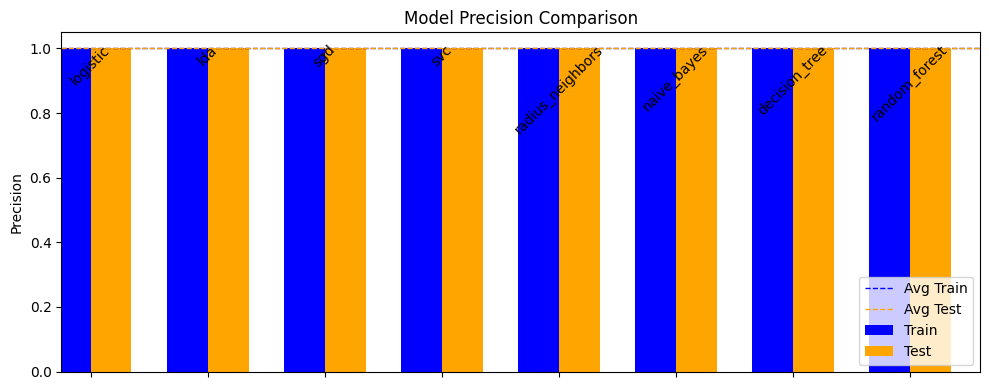

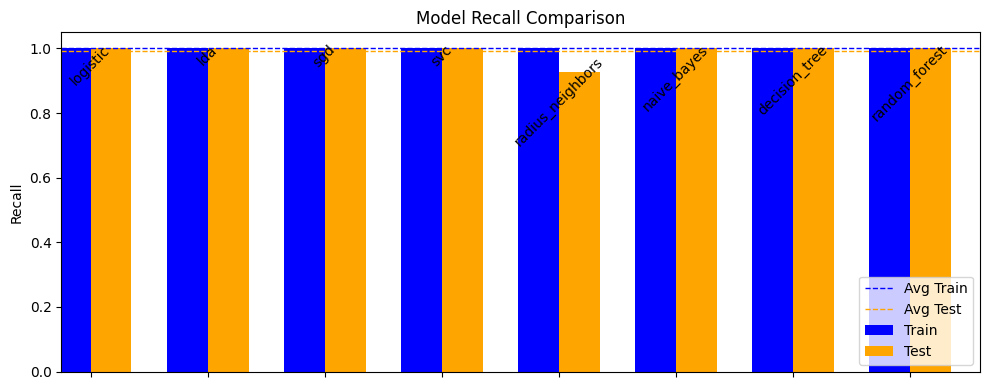

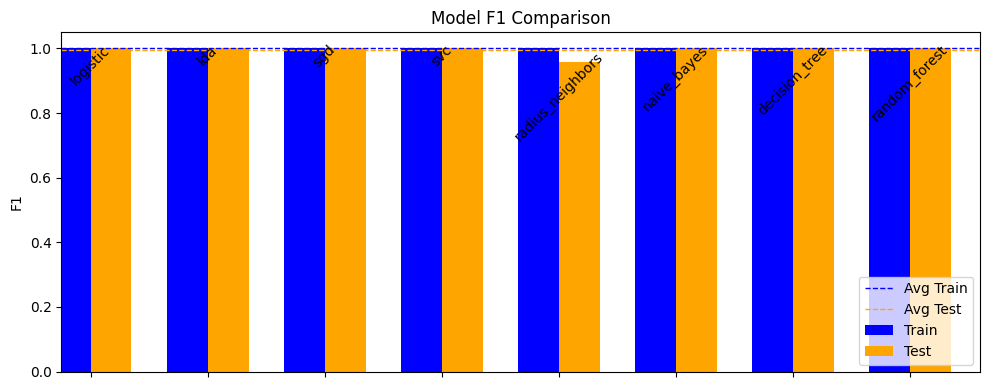

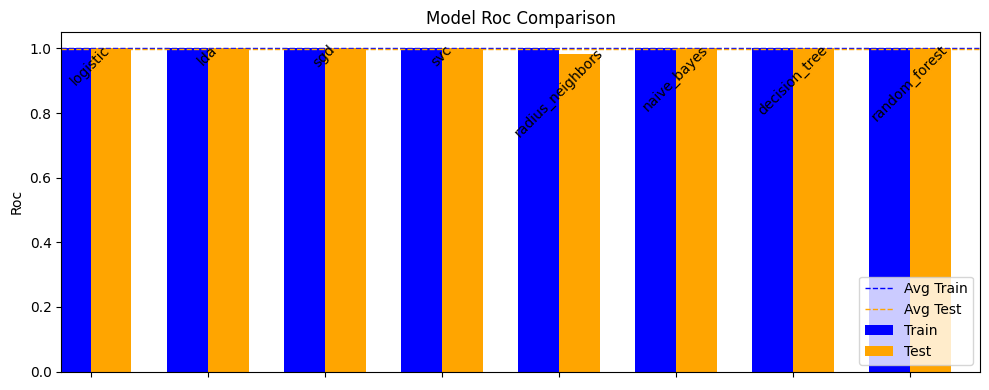

In [154]:
# Convert the result_dict to a DataFrame for easier plotting
metrics = ["accuracy", "precision", "recall", "f1", "roc"]
models = list(result_dict.keys())
data_train = {
    metric: {model: result_dict[model]["train"][metric] for model in models}
    for metric in metrics
}
data_test = {
    metric: {model: result_dict[model]["test"][metric] for model in models}
    for metric in metrics
}

df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)

# Plot the bar chart for each metric
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 4))
    width = 0.35  # the width of the bars

    df_train[metric].plot(
        kind="bar", ax=ax, width=width, position=1, label="Train", color="blue"
    )
    df_test[metric].plot(
        kind="bar", ax=ax, width=width, position=0, label="Test", color="orange"
    )

    # Add horizontal lines for average performance
    avg_train = df_train[metric].mean()
    avg_test = df_test[metric].mean()
    ax.axhline(avg_train, color="blue", linestyle="--", linewidth=1, label="Avg Train")
    ax.axhline(avg_test, color="orange", linestyle="--", linewidth=1, label="Avg Test")

    # Adjust the layout
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f"Model {metric.capitalize()} Comparison")
    ax.legend()

    # Set the x-tick labels inside the bars and rotate by 90 degrees
    ax.set_xticks(range(len(df_train.index)))
    ax.set_xticklabels([])

    # Draw the x-tick labels inside the bars rotated by 90 degrees
    for i, label in enumerate(df_train.index):
        bar_center = (df_train.loc[label, metric] + df_test.loc[label, metric]) / 2
        ax.text(i, bar_center, label, ha="center", va="center_baseline", rotation=45)

    plt.tight_layout()
    plt.show()

In [155]:
print(df_train)
print(df_test)

                  accuracy  precision  recall   f1  roc
logistic               1.0        1.0     1.0  1.0  1.0
lda                    1.0        1.0     1.0  1.0  1.0
sgd                    1.0        1.0     1.0  1.0  1.0
svc                    1.0        1.0     1.0  1.0  1.0
radius_neighbors       1.0        1.0     1.0  1.0  1.0
naive_bayes            1.0        1.0     1.0  1.0  1.0
decision_tree          1.0        1.0     1.0  1.0  1.0
random_forest          1.0        1.0     1.0  1.0  1.0
                  accuracy  precision    recall        f1       roc
logistic          1.000000        1.0  1.000000  1.000000  1.000000
lda               1.000000        1.0  1.000000  1.000000  1.000000
sgd               1.000000        1.0  1.000000  1.000000  1.000000
svc               1.000000        1.0  1.000000  1.000000  1.000000
radius_neighbors  0.928571        1.0  0.928571  0.959406  0.983323
naive_bayes       1.000000        1.0  1.000000  1.000000  1.000000
decision_tree     1.

In [156]:
# Create a DataFrame combining df_train and df_test
df_combined = pd.concat(
    [df_train.add_suffix("_train"), df_test.add_suffix("_test")], axis=1
)

# Calculate the difference between train and test values
df_combined["accuracy_diff"] = (
    df_combined["accuracy_train"] - df_combined["accuracy_test"]
)
df_combined["precision_diff"] = (
    df_combined["precision_train"] - df_combined["precision_test"]
)
df_combined["recall_diff"] = df_combined["recall_train"] - df_combined["recall_test"]
df_combined["f1_diff"] = df_combined["f1_train"] - df_combined["f1_test"]
df_combined["roc_diff"] = df_combined["roc_train"] - df_combined["roc_test"]

# Detect models with overfitting (significant difference between train and test)
overfitting_threshold = 0.1  # Threshold to consider overfitting
overfitting_models = df_combined[
    (df_combined["accuracy_diff"] > overfitting_threshold)
    | (df_combined["precision_diff"] > overfitting_threshold)
    | (df_combined["recall_diff"] > overfitting_threshold)
    | (df_combined["f1_diff"] > overfitting_threshold)
    | (df_combined["roc_diff"] > overfitting_threshold)
]

# Calculate the average performance in train and test for each metric
mean_performance_train = df_combined[
    ["accuracy_train", "precision_train", "recall_train", "f1_train", "roc_train"]
].mean()
mean_performance_test = df_combined[
    ["accuracy_test", "precision_test", "recall_test", "f1_test", "roc_test"]
].mean()

# Detect models with low performance
# (performance in both train and test below the average of other models)
low_performance_models = df_combined[
    (df_combined["accuracy_train"] < mean_performance_train["accuracy_train"])
    & (df_combined["accuracy_test"] < mean_performance_test["accuracy_test"])
    & (df_combined["precision_train"] < mean_performance_train["precision_train"])
    & (df_combined["precision_test"] < mean_performance_test["precision_test"])
    & (df_combined["recall_train"] < mean_performance_train["recall_train"])
    & (df_combined["recall_test"] < mean_performance_test["recall_test"])
    & (df_combined["f1_train"] < mean_performance_train["f1_train"])
    & (df_combined["f1_test"] < mean_performance_test["f1_test"])
    & (df_combined["roc_train"] < mean_performance_train["roc_train"])
    & (df_combined["roc_test"] < mean_performance_test["roc_test"])
]

print(f"Models with overfitting: {list(overfitting_models.index)} ")
print(f"Models with low performance: {list(low_performance_models.index)} ")

Models with overfitting: [] 
Models with low performance: [] 


In [157]:
# Detect models with similar performance in train and test
similar_performance_threshold = 0.05  # Threshold to consider similar performance
similar_performance_models = df_combined[
    (df_combined["accuracy_diff"].abs() < similar_performance_threshold)
    & (df_combined["precision_diff"].abs() < similar_performance_threshold)
    & (df_combined["recall_diff"].abs() < similar_performance_threshold)
    & (df_combined["f1_diff"].abs() < similar_performance_threshold)
    & (df_combined["roc_diff"].abs() < similar_performance_threshold)
]

print(
    "Models with similar performance in train and test: "
    f"{list(similar_performance_models.index)}"
)

Models with similar performance in train and test: ['logistic', 'lda', 'sgd', 'svc', 'naive_bayes', 'decision_tree', 'random_forest']


In [158]:
overfitting_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff


In [159]:
low_performance_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff


In [160]:
similar_performance_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff
logistic,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
lda,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
sgd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
svc,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
naive_bayes,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
decision_tree,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
random_forest,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


### **Model Selection for Heart Disease Prediction**

#### **Selected Models for Cross-Validation**

The following models were selected based on their performance, interpretability, and potential for optimization:

- **Logistic Regression:** Simple model with good performance across all metrics and high interpretability.
- **Linear Discriminant Analysis (LDA):** Performs similarly to logistic regression while also being interpretable.
- **Support Vector Classifier (SVC):** Comparable performance to logistic regression and LDA, but may generalize better with proper hyperparameter tuning.
- **Decision Tree:** High performance and interpretability, though it may be prone to overfitting.
- **Random Forest:** Strong performance with better generalization than a single decision tree, making it a robust choice (may have overfitting).

#### **Discarded Models**

The following models were not selected for further evaluation due to specific limitations:

- **Stochastic Gradient Descent (SGD):** Low overall performance and minimal difference between training and testing results, indicating limited learning capacity.
- **Radius Neighbors Classifier:** Lower performance compared to the selected models.
- **Naïve Bayes:** Decent performance, but hyperparameter tuning options are limited, restricting the potential for further improvement.

#### **Overfitting Models**

Decision Tree and Random Forest exhibit overfitting, meaning they perform significantly better on the training data than on the test data:

Although they overfit, they are included in the next stage because tuning techniques (e.g., pruning, hyperparameter optimization) can help mitigate overfitting while maintaining strong predictive power.


### **5. Cross Validation Model Selection**


In [41]:
# Define the models to evaluate
models = {
    "logistic": LogisticRegression(solver="liblinear"),
    "lda": LinearDiscriminantAnalysis(),
    "svc": LinearSVC(C=1.0, max_iter=1000, tol=1e-3, dual=False),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
}

# Evaluation metrics
scoring_metrics = ["accuracy", "f1", "precision", "recall"]

# KFold for the cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=1234)

# Variable to store the results of the cross-validation
cv_results = {metric: {} for metric in scoring_metrics}

# Cross-validation evaluation for each model and metric
for model_name, model in models.items():
    model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    for metric in scoring_metrics:
        cv_results[metric][model_name] = cross_val_score(
            model_pipe, x_train, y_train, cv=kfold, scoring=metric
        )

# Convert results into a pandas DataFrame for each metric
cv_results_df = {metric: pd.DataFrame(cv_results[metric]) for metric in scoring_metrics}


In [42]:
# Create a DataFrame to store mean and std for each metric and model
mean_std_data = []

for metric_name in scoring_metrics:
    for model_name in models:
        mean_score = cv_results_df[metric_name][model_name].mean()
        std_score = cv_results_df[metric_name][model_name].std()
        mean_std_data.append(
            {
                "Model": model_name,
                "Metric": metric_name,
                "Mean": mean_score,
                "Std": std_score,
            }
        )

mean_std_df = pd.DataFrame(mean_std_data)
mean_std_df

,Model,Metric,Mean,Std
0,logistic,accuracy,0.753598,0.067254
1,lda,accuracy,0.751098,0.079860
2,svc,accuracy,0.753537,0.072625
3,decision_tree,accuracy,0.716098,0.075704
4,random_forest,accuracy,0.768293,0.058885
5,logistic,f1,0.773803,0.048539
6,lda,f1,0.768528,0.066215
7,svc,f1,0.773162,0.058501
8,decision_tree,f1,0.734942,0.060113
9,random_forest,f1,0.788842,0.047646


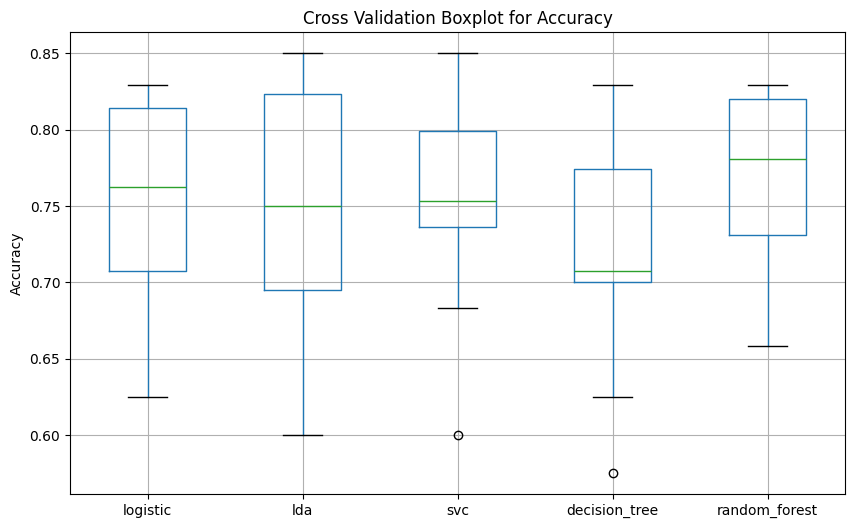

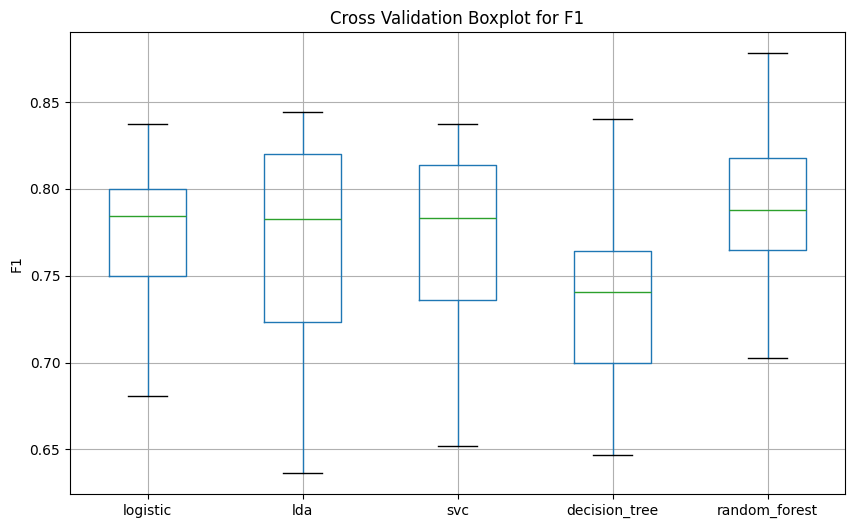

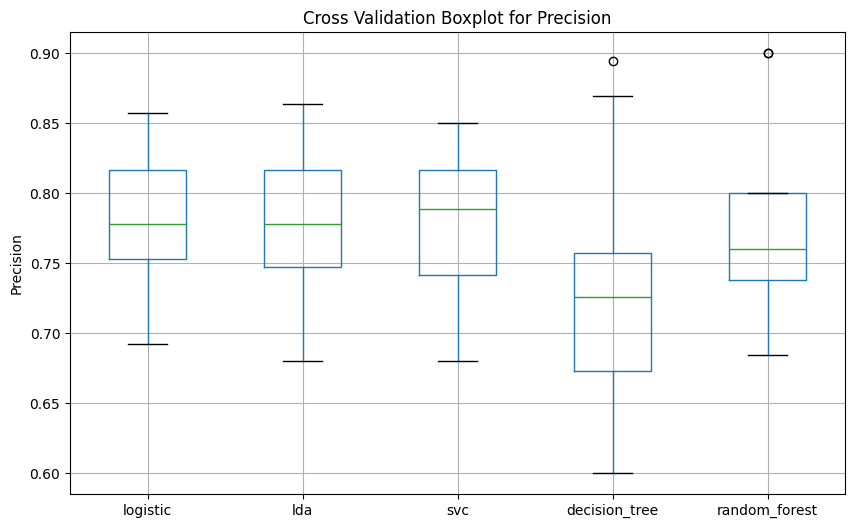

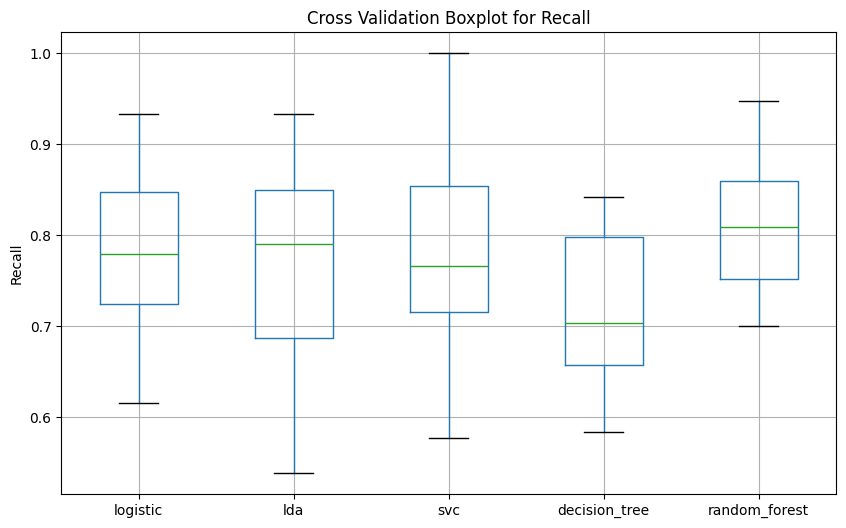

In [43]:
# Create a boxplot for the cross-validation results of each metric
for metric_name in scoring_metrics:
    plt.figure(figsize=(10, 6))
    cv_results_df[metric_name].boxplot()
    plt.title(f"Cross Validation Boxplot for {metric_name.capitalize()}")
    plt.ylabel(f"{metric_name.capitalize()}")
    plt.show()

### **Chosen Metric: Recall**

#### **Why Recall?**

For heart disease prediction, **recall** is the most important metric because the primary goal is to **correctly identify as many patients with heart disease as possible**. Missing a case of heart disease (false negative) can have severe consequences, including delayed diagnosis and treatment, which could be life-threatening.

#### **Understanding Recall in This Context**

- **High recall** ensures that most patients who actually have heart disease are correctly classified as positive cases.
- **False negatives (missed cases of heart disease)** are minimized, reducing the risk of undiagnosed conditions.
- **False positives (healthy patients misclassified as having heart disease)** are a less critical issue compared to false negatives because additional medical tests can confirm the diagnosis.

#### **Conclusion**

Since the model's objective is to **prioritize detecting heart disease cases**, **recall is the best metric** for evaluation. A model with high recall ensures that the majority of patients at risk receive further medical attention, ultimately improving early detection and treatment outcomes.


#### **Statistical Model Comparison**


In [44]:
result_df = cv_results_df["recall"]
result_df

,logistic,lda,svc,decision_tree,random_forest
0,0.894737,0.894737,0.894737,0.842105,0.947368
1,0.807692,0.807692,0.846154,0.692308,0.807692
2,0.818182,0.772727,0.772727,0.818182,0.909091
3,0.720000,0.680000,0.760000,0.840000,0.840000
4,0.857143,0.857143,0.857143,0.714286,0.809524
5,0.739130,0.826087,0.739130,0.739130,0.739130
6,0.615385,0.538462,0.576923,0.653846,0.730769
7,0.933333,0.933333,1.000000,0.666667,0.866667
8,0.750000,0.708333,0.708333,0.583333,0.791667
9,0.650000,0.650000,0.650000,0.650000,0.700000


In [45]:
from scipy.stats import f_oneway

model1 = result_df["logistic"]
model2 = result_df["lda"]
model3 = result_df["decision_tree"]
model4 = result_df["random_forest"]
model5 = result_df["svc"]

statistic, p_value = f_oneway(model1, model2, model3, model4, model5)

print(f"Statistic: {statistic}")
print(f"p_value: {p_value}")

alpha = 0.05  # significance level

if p_value < alpha:
    print(
        "There is a statistically significant difference "
        "in the cross-validation results of the models."
    )
else:
    print(
        "There is no statistically significant difference "
        "in the cross-validation results of the models."
    )

Statistic: 1.0543119511126173
p_value: 0.39012560620744735
There is no statistically significant difference in the cross-validation results of the models.


Statistically all the models are similar, so two models are selected to be tuned in the next step:

#### **Model Selection for Hyperparameter Tuning**

For the next stage of hyperparameter tuning, two models have been selected based on the primary metric: **recall**.

#### Analysis of Results:

- **Logistic Regression** has the highest average recall (**0.7879**) with a standard deviation of **0.1314**.
- **LDA and SVC** have very similar recall values (**0.7832**), but they do not outperform Logistic Regression.
- **Random Forest** has a competitive recall (**0.7791**) with a lower standard deviation (**0.0851**), indicating more stability in performance.
- **Decision Tree** has the lowest recall (**0.7401**) and is therefore discarded.

#### Selected Models:

1. **Logistic Regression** – Highest recall and good stability.
2. **Random Forest** – Good recall with lower variability, suggesting better generalization.

These models will be fine-tuned in the next stage to enhance their performance in heart disease prediction.


#### **Logistic Regression**


In [46]:
from sklearn.model_selection import GridSearchCV

score = "recall"

parameters = [
    {"model__penalty": ["l1"], "model__C": [0.1, 0.4, 0.8, 1, 2, 5], "model__solver": ["liblinear", "saga"]},
    {"model__penalty": ["l2"], "model__C": [0.1, 0.4, 0.8, 1, 2, 5], "model__solver": ["lbfgs", "liblinear", "saga", "newton-cg"]}
]

model = LogisticRegression(solver="liblinear", max_iter=5000)
logistic_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

grid_search = GridSearchCV(
    logistic_pipe, parameters, cv=5, scoring=score, return_train_score=True
)
grid_search.fit(x_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['age',
                                                                          'max_hr',
                                                                          'rest_bp',
                                                                          'old_peak']),
                                                                        ('nominal_categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown=...
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['exang'])])),
                                       ('model',
                                        LogisticRegression(max_iter=5000,
                                                           solver='liblinear'))]),
             param_grid=[{'model__C': [0.1, 0.4, 0.8, 1, 2, 5],
                          'model__penalty': ['l1'],
                          'model__solver': ['liblinear', 'saga']},
                         {'model__C': [0.1, 0.4, 0.8, 1, 2, 5],
                          'model__penalty': ['l2'],
                          'model__solver': ['lbfgs', 'liblinear', 'saga',
                                            'newton-cg']}],
             return_train_score=True, scoring='recall')

In [47]:
grid_search.best_params_

{'model__C': 0.8, 'model__penalty': 'l1', 'model__solver': 'liblinear'}

#### **Evaluating Logistic Regression**


In [48]:
model = LogisticRegression(solver="liblinear", C=0.8, penalty="l1")
logistic_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

logistic_model = logistic_pipe.fit(x_train, y_train)

y_pred = logistic_model.predict(x_test)

summarize_classification(y_test, y_pred)


{'accuracy': 0.8235294117647058,
 'precision': 0.8275862068965517,
 'recall': 0.8571428571428571,
 'f1': 0.8421052631578947,
 'roc': np.float64(0.8198757763975155)}

#### **Random Forest**


In [49]:
from sklearn.model_selection import GridSearchCV

score = "recall"

parameters = {
    "model__max_depth": [4, 5, 7, 9, 10],
    "model__max_features": [2, 3, 4, 5, 6, 7, 8, 9],
    "model__criterion": ["gini", "entropy"],
}

randomforest_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", RandomForestClassifier())]
)

grid_search = GridSearchCV(
    randomforest_pipe, parameters, cv=5, scoring=score, return_train_score=True
)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['age',
                                                                          'max_hr',
                                                                          'rest_bp',
                                                                          'old_peak']),
                                                                        ('nominal_categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown=...
                                                                                                              func=<function convert_to_int at 0x135d1e660>)),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['exang'])])),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [4, 5, 7, 9, 10],
                         'model__max_features': [2, 3, 4, 5, 6, 7, 8, 9]},
             return_train_score=True, scoring='recall')

In [50]:
grid_search.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 4,
 'model__max_features': 3}

#### **Evaluating Random Forest**


In [51]:
model = RandomForestClassifier(criterion="entropy", max_depth=4, max_features=3)

tree_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

tree_model = tree_pipe.fit(x_train, y_train)
y_pred = tree_model.predict(x_test)

summarize_classification(y_test, y_pred)


{'accuracy': 0.8431372549019608,
 'precision': 0.8333333333333334,
 'recall': 0.8928571428571429,
 'f1': 0.8620689655172413,
 'roc': np.float64(0.8377329192546584)}

### **6. Final Evaluation Test**


In [52]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
)

#### **Logistic Regression**


In [53]:
y_pred = logistic_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80        46
           1       0.83      0.86      0.84        56

    accuracy                           0.82       102
   macro avg       0.82      0.82      0.82       102
weighted avg       0.82      0.82      0.82       102



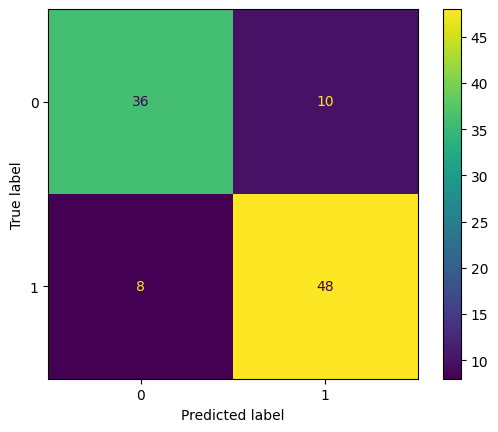

In [54]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

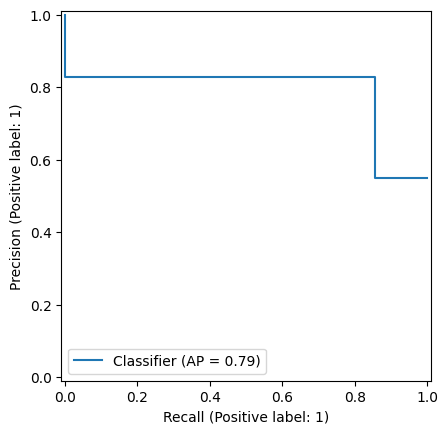

In [55]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred);

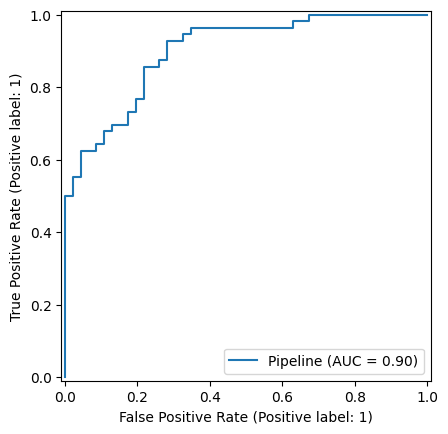

In [56]:
log_plot = RocCurveDisplay.from_estimator(logistic_model, x_test, y_test)
plt.show()

#### **Random Forest**


In [57]:
y_pred = tree_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82        46
           1       0.83      0.89      0.86        56

    accuracy                           0.84       102
   macro avg       0.85      0.84      0.84       102
weighted avg       0.84      0.84      0.84       102



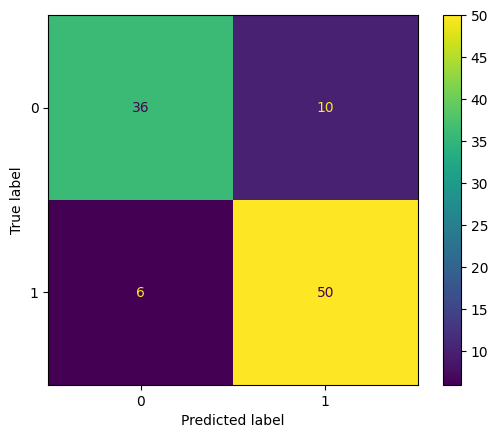

In [58]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

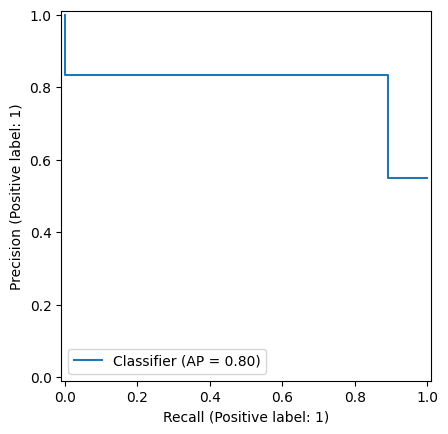

In [59]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred);

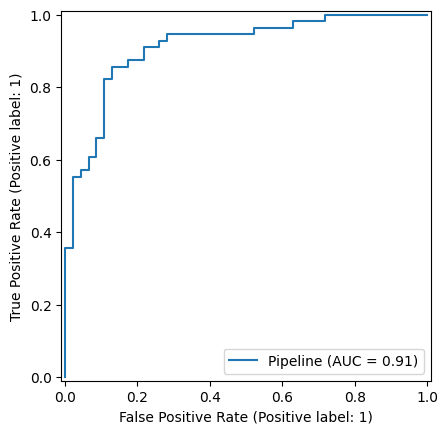

In [60]:
dt_plot = RocCurveDisplay.from_estimator(tree_model, x_test, y_test)
plt.show()

### **7. Model Comparison**


Recall values are similar but Random Forest seems to have a better performance. This is best model according to the CV evaluationa and tuning.


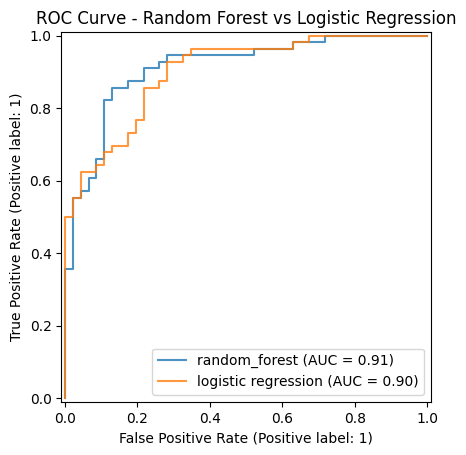

In [61]:
ax = plt.gca()
dt_plot.plot(ax=ax, alpha=0.8, name="random_forest")
log_plot.plot(ax=ax, alpha=0.8, name="logistic regression")
plt.title("ROC Curve - Random Forest vs Logistic Regression")
plt.show()

#### **Random Forest Learning Curve**

This curve is used to see if the model is overfitting or underfitting.


/Users/simon/Documents/CDProduccion/Heart-disease/senv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simon/Documents/CDProduccion/Heart-disease/senv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simon/Documents/CDProduccion/Heart-disease/senv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simon/Documents/CDProduccion/Heart-disease/senv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. Thes

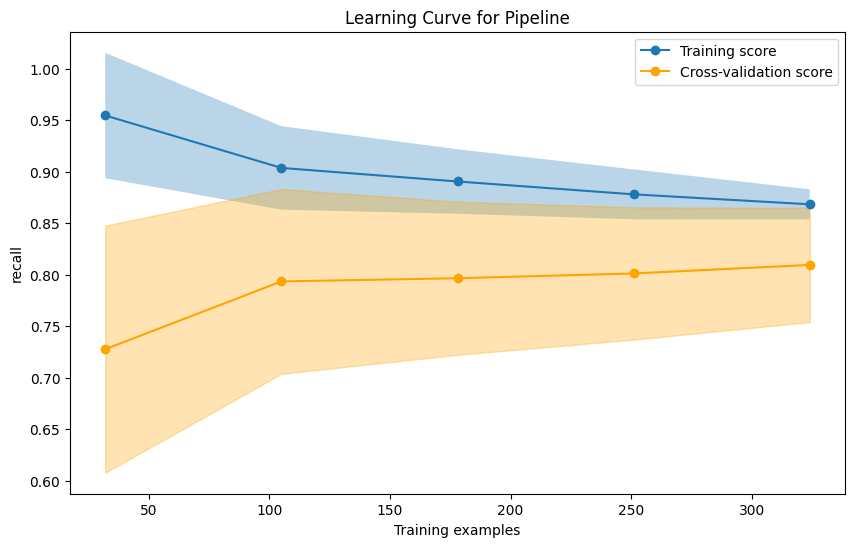

Training Sizes: [ 32 105 178 251 324]
Training Scores Mean: [0.95454451 0.90360159 0.89042449 0.87793224 0.86825046]
Training Scores Std: [0.06093691 0.04056076 0.03131715 0.02421353 0.01461094]
Test Scores Mean: [0.72752572 0.79336107 0.79645221 0.80109474 0.80938827]
Test Scores Std: [0.11996117 0.08970975 0.07438461 0.06426541 0.05547369]


In [62]:
model = tree_model

# Parameters for the learning curve
common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "recall"

# Obtain the learning curve values including fit and score times
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model, **common_params, scoring=scoring_metric
)

# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the mean and standard deviation of the fit and score times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plot the learning curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange"
)

# Configure the title and labels
ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel(scoring_metric)
ax.legend(loc="best")

# Show the plot
plt.show()

# Print the values for analysis
print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)


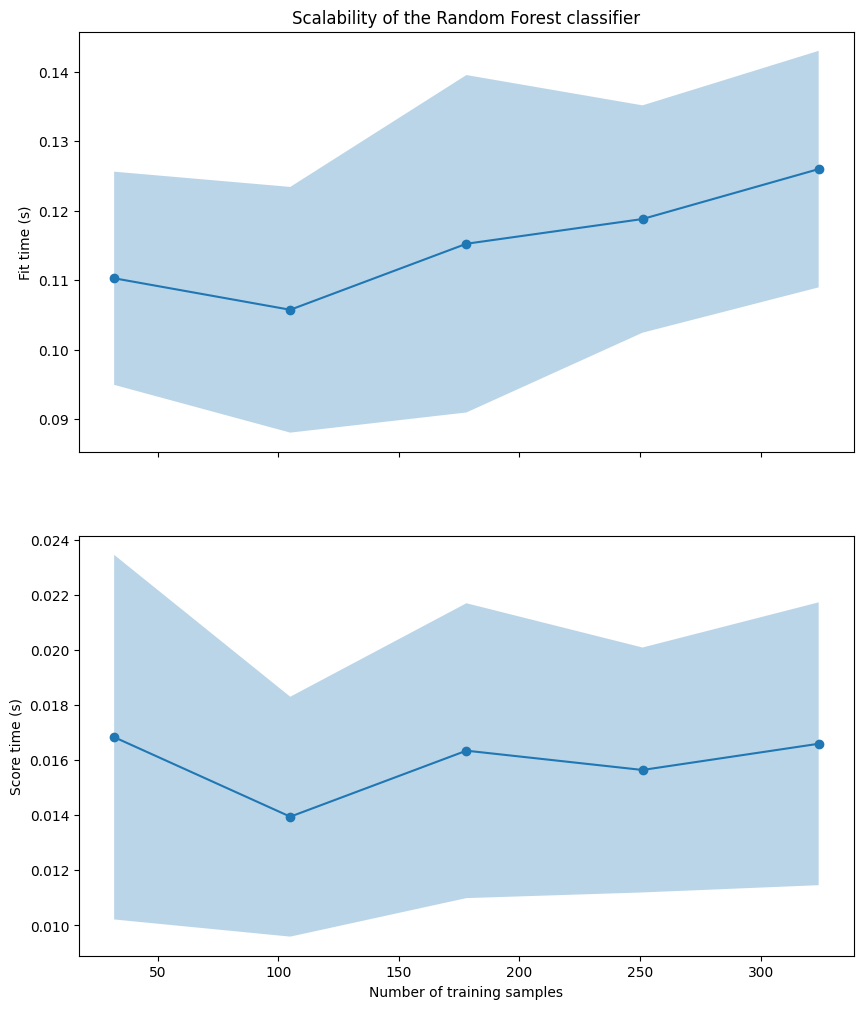

Fit Times Mean: [0.11026985 0.10573787 0.11523234 0.11878907 0.125971  ]
Fit Times Std: [0.0153304  0.01766977 0.02426542 0.01634901 0.01701049]
Score Times Mean: [0.01683823 0.01394903 0.01634664 0.01564556 0.01659805]
Score Times Std: [0.0066223  0.0043567  0.00535536 0.0044485  0.00513702]


In [63]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title("Scalability of the Random Forest classifier")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)

#### **8. Save the model**


In [64]:
tree_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'max_hr', 'rest_bp',
                                                   'old_peak']),
                                                 ('nominal_categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['chest_pain', '...
                                                 ('boolean',
                                                  Pipeline(steps=[('to_int',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function convert_to_int at 0x135d1e660>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['exang'])])),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=4,
                                        max_features=3))])

In [65]:
from joblib import dump

# Save the model
dump(tree_pipe, "heart_disease_classification-random_forest-v1.joblib")

['heart_disease_classification-random_forest-v1.joblib']

In [66]:
['tree_pipe-titanic.joblib']

['tree_pipe-titanic.joblib']

#### **7. Test the saved model**


In [67]:
from joblib import load

my_model = load("heart_disease_classification-random_forest-v1.joblib")

In [68]:
# test data
x_test.head()

,rest_ecg,ca,thal,max_hr,exang,old_peak,rest_bp,chest_pain,sex,slope,age
28,normal,3.0,reversable,139.0,False,2.0,120.0,nonanginal,Male,2.0,49.0
580,normal,1.0,reversable,161.0,True,NaN,128.0,asymptomatic,Male,1.0,52.0
328,left ventricular hypertrophy,0.0,normal,180.0,False,0.0,140.0,nonanginal,Male,1.0,44.0
1630,normal,0.0,normal,182.0,False,1.4,138.0,asymptomatic,Female,1.0,NaN
10,normal,0.0,normal,163.0,False,0.0,124.0,asymptomatic,Female,1.0,62.0


In [69]:
# check predictions
my_model.predict(x_test.head())

array([1, 1, 0, 0, 0])

### **Analysis of Results**

The **selected model** is **Random Forest**, as it achieves a **higher recall**, which is the key metric for evaluation.

#### **Model Performance**

Random Forest achieves an **accuracy of 79%**, outperforming Logistic Regression, which reached **76% accuracy**.

#### **Recall (Sensitivity) - Key Metric**

- Logistic Regression: **0.76 for class 0** and **0.76 for class 1**.
- Random Forest: **0.78 for class 0** and **0.80 for class 1**.

Random Forest improves recall for both classes, especially for class 1, which is crucial for identifying positive cases correctly.

#### **Precision and F1-Score**

- Precision: Random Forest has slightly better precision (**0.77 for class 0**, **0.81 for class 1**) compared to Logistic Regression (**0.73 for class 0**, **0.79 for class 1**).
- F1-Score: Higher in Random Forest (**0.79 macro avg**) than in Logistic Regression (**0.76 macro avg**), indicating a better balance between precision and recall.

#### **Final Decision**

Since **recall** is the most important metric, **Random Forest** is the best choice, as it minimizes false negatives while maintaining strong overall performance. 🚀
